In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

new_columns = [
    "par_id",      # 1 (integer ID)
    "art_id",      # @@24942188 (article identifier)
    "topic",       # hopeless (PCL category)
    "country",     # ph (country code)
    "text",        # Full text content
    "label"        # 0 (binary label)
]

# Read main dataset - skip 4 disclaimer rows
df = pd.read_csv(
    "data/dontpatronizeme_pcl.tsv",
    sep="\t",
    header=None,
    skiprows=4,
    names=new_columns,
    on_bad_lines='warn'
)


## Preprocessing

In [3]:
# Read train/dev splits
train_val_labels = pd.read_csv("data/train_semeval_parids-labels.csv")
test_labels = pd.read_csv("data/dev_semeval_parids-labels.csv")

# Convert string labels to lists
def parse_labels(label_str: str) -> list[int]:
    return [int(x) for x in label_str.strip("[]").replace(" ", "").split(",")]

# Process labels dataframes
for labels_df in [train_val_labels, test_labels]:
    labels_df['labels'] = labels_df['label'].apply(parse_labels)
    labels_df.drop('label', axis=1, inplace=True)

# Join with main data
train_val_df = df.merge(train_val_labels, on="par_id", how="inner")
test_df = df.merge(test_labels, on="par_id", how="inner")

In [14]:
train_val_df.head()
train_val_df[train_val_df['label'] == 4]

,par_id,art_id,topic,country,text,label,labels,text_length
116,118,@@24885862,in-need,za,This is the rhetoric of what anthropologist La...,4,"[1, 0, 0, 1, 0, 1, 0]",343
188,195,@@4478900,homeless,gb,Housing Minister Grant Shapps added : ' The pl...,4,"[1, 0, 0, 1, 0, 0, 0]",133
190,197,@@7384248,vulnerable,us,It is understandable to want to protect one 's...,4,"[1, 0, 1, 1, 1, 1, 0]",674
221,228,@@4268545,vulnerable,gb,If these problems are not tackled there is eve...,4,"[1, 0, 0, 1, 1, 1, 0]",228
240,248,@@17606348,hopeless,ke,""" Clear evidence of outstanding miraculous occ...",4,"[0, 0, 0, 0, 1, 1, 0]",150
...,...,...,...,...,...,...,...,...
8360,10333,@@4473137,hopeless,ca,""" For the kids , it shows that someone loves t...",4,"[1, 0, 1, 1, 0, 1, 0]",306
8362,10352,@@21102155,poor-families,lk,The next immediate problem that cropped up was...,4,"[1, 0, 0, 0, 0, 1, 0]",398
8364,10379,@@30026901,poor-families,za,""" Many children from poor families and working...",4,"[0, 0, 1, 1, 1, 1, 0]",262
8366,10400,@@25998036,homeless,pk,""" They 're a little bit behind me I think , "" ...",4,"[1, 1, 0, 0, 0, 0, 0]",346


## Data distribution analysis

#### Analysis the label frequencies. Label contains category 0 to 4.


Train & Validation Set Label Distribution:
label
0    6825
1     756
2     126
3     369
4     299
Name: count, dtype: int64


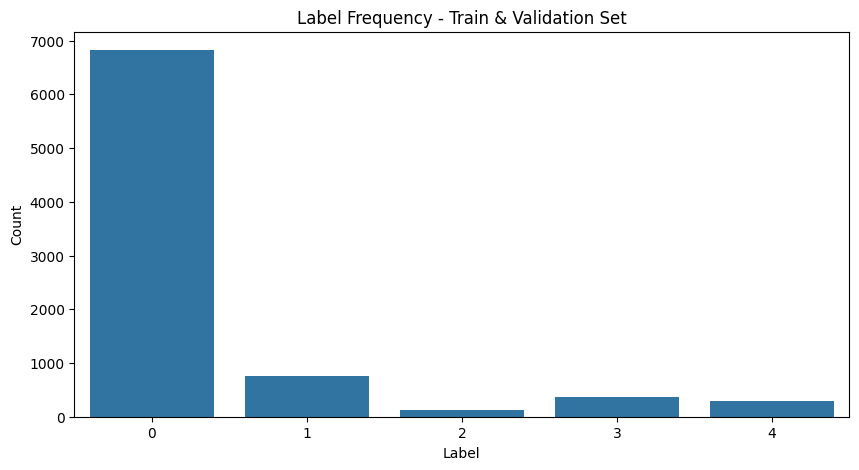


Test Set Label Distribution:
label
0    1704
1     191
2      18
3      89
4      92
Name: count, dtype: int64


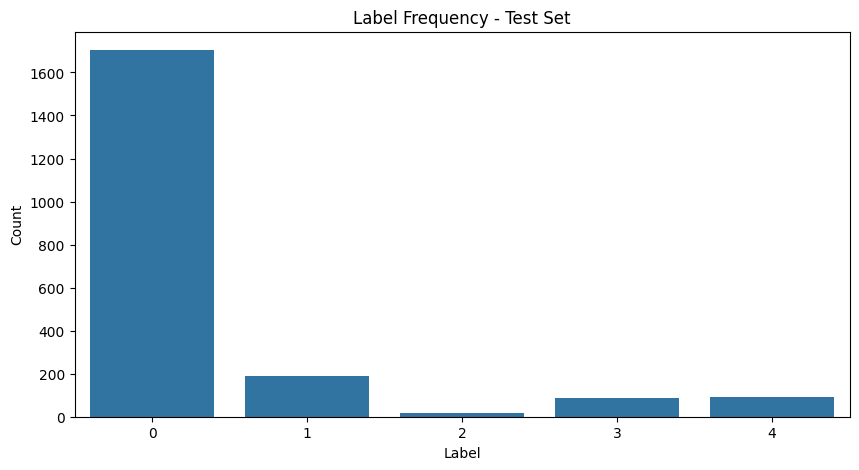

In [15]:
# Label frequency analysis
def analyze_labels(df, name):
    # Explode the list of labels into individual rows
    label_counts = df['label'].value_counts().sort_index()
    
    print(f"\n{name} Set Label Distribution:")
    print(label_counts)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_counts.index, y=label_counts.values)
    plt.title(f'Label Frequency - {name} Set')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

# Analyze all splits
for df, name in [(train_val_df, 'Train & Validation'), (test_df, 'Test')]:
    analyze_labels(df, name)


#### Process and analyze the frequency of PCL label grouping. 


Train & Validation Set PCL Group Distribution:
Negative PCL (0,1): 7581 (90.5%)
Positive PCL (2,3,4): 794 (9.5%)


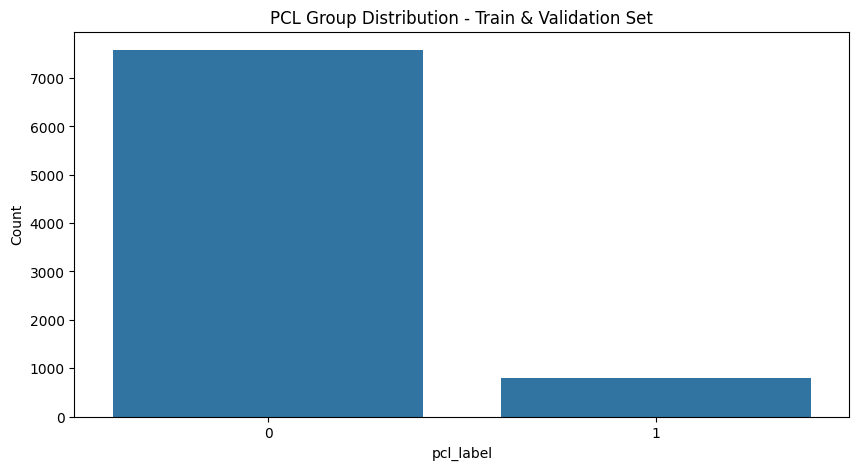


Test Set PCL Group Distribution:
Negative PCL (0,1): 1895 (90.5%)
Positive PCL (2,3,4): 199 (9.5%)


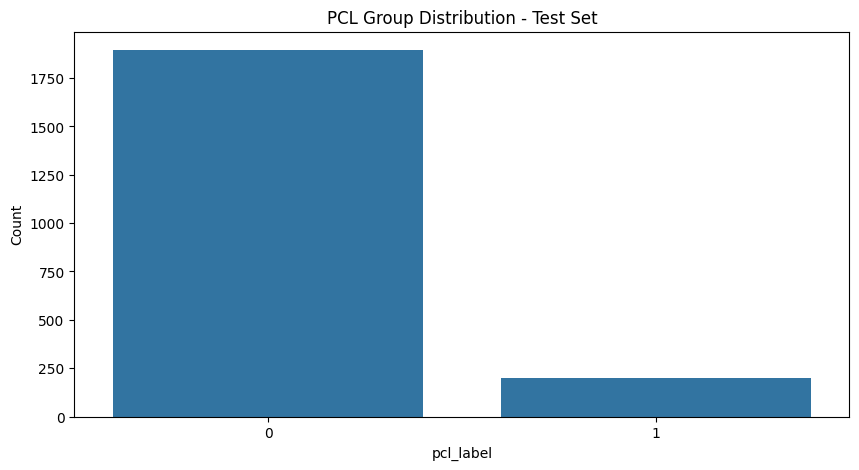

In [23]:

# Add PCL positivity column to both dataframes
train_val_df['pcl_label'] = train_val_df['label'].apply(
    lambda x: 0 if x in {0, 1} else 1)
test_df['pcl_label'] = test_df['label'].apply(
    lambda x: 0 if x in {0, 1} else 1)

# Analyze PCL label groupings
def analyze_pcl_groups(df, name):
    # Get counts from precomputed column
    counts = df['pcl_label'].value_counts()
    negative_pcl = counts.get(0, 0)
    positive_pcl = counts.get(1, 0)
    
    print(f"\n{name} Set PCL Group Distribution:")
    print(f"Negative PCL (0,1): {negative_pcl} ({negative_pcl/len(df):.1%})")
    print(f"Positive PCL (2,3,4): {positive_pcl} ({positive_pcl/len(df):.1%})")
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=counts.index, y=counts.values)
    plt.title(f'PCL Group Distribution - {name} Set')
    plt.ylabel('Count')
    plt.show()

# Analyze both splits
for df, name in [(train_val_df, 'Train & Validation'), (test_df, 'Test')]:
    analyze_pcl_groups(df, name)


#### Distribution of Length in corrlation to PCL labelling

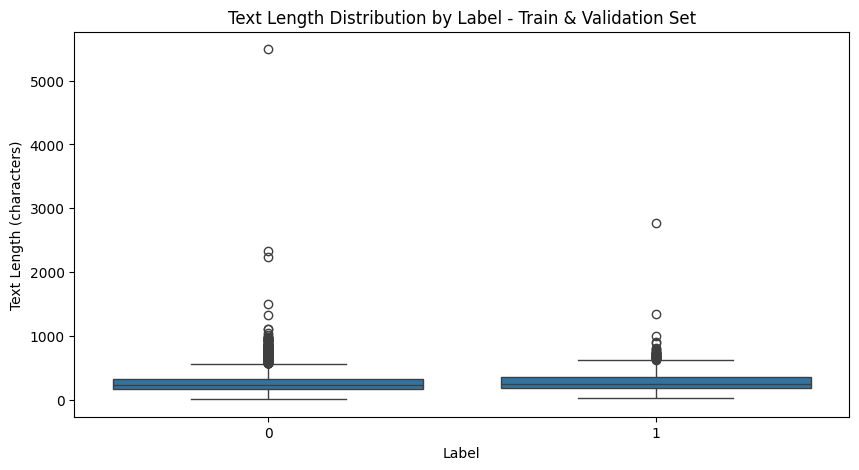

Train & Validation Set Text Length-Label Correlation: 0.037


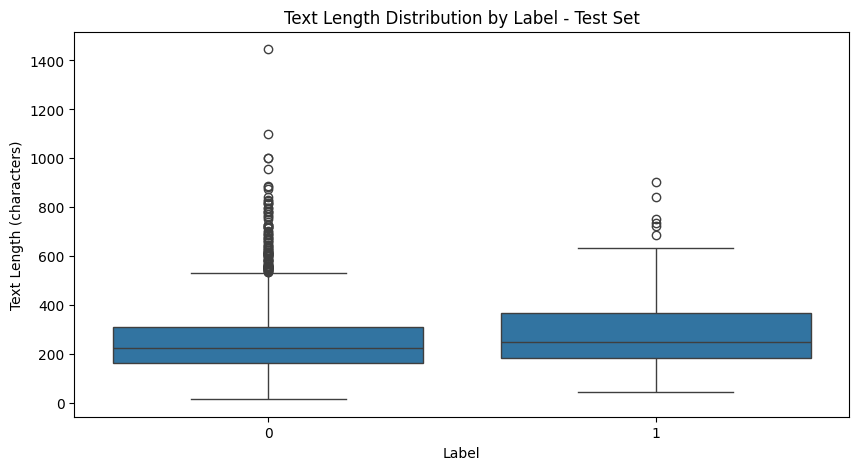

Test Set Text Length-Label Correlation: 0.062


In [26]:

# Add another cell for text length analysis
# Calculate text lengths
train_val_df['text_length'] = train_val_df['text'].str.len()
test_df['text_length'] = test_df['text'].str.len()

# Correlation between text length and labels
def analyze_length_correlation(df, name):
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df['pcl_label'], y='text_length', data=df)
    plt.title(f'Text Length Distribution by Label - {name} Set')
    plt.xlabel('Label')
    plt.ylabel('Text Length (characters)')
    plt.show()
    
    # Calculate correlation (convert label list to single value)
    correlation = df['text_length'].corr(df['pcl_label'])
    print(f"{name} Set Text Length-Label Correlation: {correlation:.3f}")

for df, name in [(train_val_df, 'Train & Validation'), (test_df, 'Test')]:
    analyze_length_correlation(df, name)

#### Anaylze the length correlation using point-biserail correlation analysis and stratified binning and point plot.

Train & Validation: Balanced Point-biserial: r=0.064 (p=0.0107)


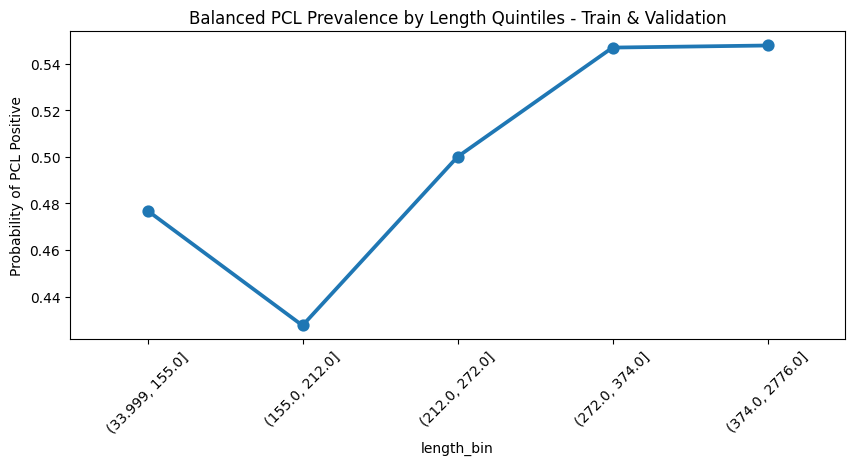

Test: Balanced Point-biserial: r=0.109 (p=0.0304)


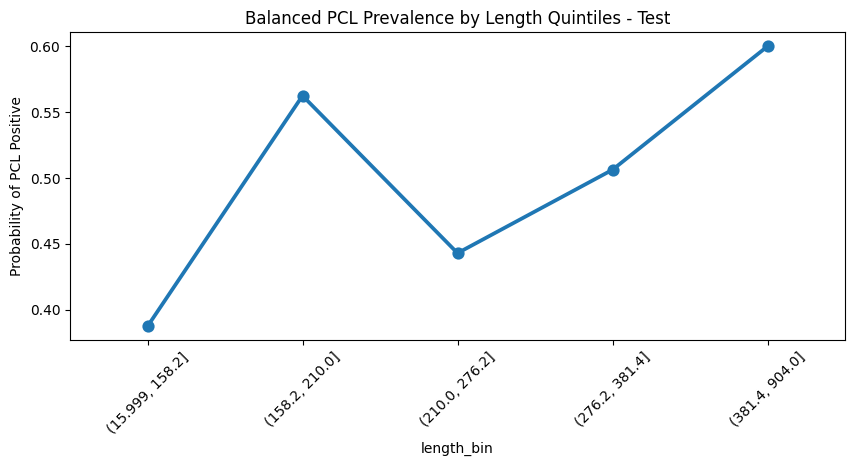

In [62]:
def analyze_length_correlation(df, name):
    from scipy.stats import pointbiserialr
    from sklearn.utils import resample
    
    # Balance samples using downsampling
    majority = df[df['pcl_label'] == 0]
    minority = df[df['pcl_label'] == 1]
    balanced_majority = resample(majority, 
                               n_samples=len(minority), 
                               replace=False,
                               random_state=42)
    balanced_df = pd.concat([balanced_majority, minority])

    # Point-biserial correlation analysis
    corr, p_corr = pointbiserialr(balanced_df['text_length'], 
                                balanced_df['pcl_label'])
    print(f"{name}: Balanced Point-biserial: r={corr:.3f} (p={p_corr:.4f})")

    # Stratified binning and point plot
    balanced_df['length_bin'] = pd.qcut(balanced_df['text_length'], q=5)
    bin_analysis = balanced_df.groupby('length_bin', observed=False)['pcl_label'].agg(['mean', 'count'])
    
    plt.figure(figsize=(10, 4))
    sns.pointplot(data=bin_analysis.reset_index(), x='length_bin', y='mean',
              errorbar=('ci', 95),
              linestyle='-',
              markers='o')
    plt.title(f'Balanced PCL Prevalence by Length Quintiles - {name}')
    plt.xticks(rotation=45)
    plt.ylabel('Probability of PCL Positive')
    plt.show()

for df, name in [(train_val_df, 'Train & Validation'), (test_df, 'Test')]:
    analyze_length_correlation(df, name)

In [4]:
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, shuffle=False)

print(val_df.head())

      par_id      art_id       topic country  \
6700    6838  @@13786523     refugee      za   
6701    6839  @@23413758       women      gh   
6702    6840   @@9745516    homeless      au   
6703    6841   @@1864808    homeless      tz   
6704    6842  @@14327774  vulnerable      lk   

                                                   text  label  \
6700  Sheena Jonker , head mediator of Access to Jus...      0   
6701  While the President has had occasions to recei...      0   
6702  The decision comes following a series of Tweet...      1   
6703             Strong winds leave 180 people homeless      0   
6704  Voice : - Elders who live outside major cities...      0   

                     labels  
6700  [0, 0, 0, 0, 0, 0, 0]  
6701  [0, 0, 0, 0, 0, 0, 0]  
6702  [0, 0, 0, 0, 0, 0, 0]  
6703  [0, 0, 0, 0, 0, 0, 0]  
6704  [0, 0, 0, 0, 0, 0, 0]  
